Basic NLP with TensorFlow - Prediction of real or fake disaster tweets
===

Wesley Galvão 

Aug, 2020


![Twitter image](https://tecnoblog.net/wp-content/uploads/2019/03/twitter-700x394.jpg)
   
Image from [Tecnoblog](https://tecnoblog.net/324200/como-ver-todos-os-retweets-com-comentarios-do-twitter-quoted-replies/)

# Introduction

This notebook contains an introductory approach to Natural Language Processing techniques in order to model and build a machine model that predicts which Tweets are about real disasters and which one's aren't. 

For this purpose, techniques of exploratory data analysis, cleaning and tensorflow library were used.

This work was based on others and was properly referenced in the references section.

I hope you enjoy reading.  

# About the Dataset

According the [competition description](https://www.kaggle.com/c/nlp-getting-started/data), the data characteristics are:

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* he location the tweet was sent from (may also be blank)

Columns

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Importing required libraries

In [ ]:
import pandas as pd # data processing
import numpy as np  # linear algebra

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# TensorFlow and libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Preprocessing libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

import gensim
import string
# Counter function
from collections import Counter

#WordCloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
# create text with Markdown from within code cells¶
from IPython.display import Markdown as md 

## Loading dataset

In [ ]:
# Load the dataset
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

## Dataset shape

In [ ]:
# Head
train_df.head(4)

In [ ]:
# Datasets shape
print('Train dataset:\n{} rows\n{} columns'.format(train_df.shape[0], train_df.shape[1]))
print('\nTest dataset:\n{} rows\n{} columns'.format(test_df.shape[0], test_df.shape[1]))

# Exploratory Data Analysis

In this section we'll perform some EDA techiniques, like chart plotting and features summarising. 

## Target variable characteristics

Analyses of `target` column.

### Amount

We can get the amount of real disaster and not real disaster tweets. 

In [ ]:
# Count target values by its factor
x = train_df.target.value_counts()
md("The amount disaster tweets is {}. And the amount for not disaster is {}.".
     format(x[1], x[0]))

In [ ]:
# Add title
plt.title("Amount of tweets - Disaster(1) or not(0)")
# Bar chart showing amount of both target values
sns.barplot(x.index, x)
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Target")

### Proportion

We can also calculate target values proportion and visualize them. 

In [ ]:
proportion = x/train_df.shape[0] # Compute the tweets proportion by target
md("The percentual of disaster tweets is {}%, and {}% for not disaster.".
     format(round(proportion[1]*100,0),round(proportion[0]*100, 0)))

In [ ]:
# Reference: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
# Pie chart

fig1, ax1 = plt.subplots()
ax1.pie(proportion, 
        explode = (0, 0.1), # only "explode" the 2nd slice
        labels  = ['Not disaster', 'Disaster'], 
        autopct = '%1.1f%%',
        shadow = True, 
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentual of tweets")
plt.show()

## Text variable characteristics

To understand the distribution of tweets, it's necessary explore the `text` column. First, we create two new features to get some statistics.

### New features

The new features are number of characters (or text lenght) and number of words for each tweet.

In [ ]:
# Create a new feature with text lenght, or number of characters
train_df['length'] = train_df['text'].str.len()
# Create a new feature with number of words
train_df['num_words'] = train_df['text'].str.split().map(lambda x: len(x))
train_df.head(3)

### Text lenght

Main statistics

In [ ]:
# Text length summary by target
train_df.groupby(['target']).length.describe()

Now, we plot the histogram to visualize the distribution. 

In [ ]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(plt.hist, "length")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Text lenght by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

### Number of words

Similarly, here are some statistics and graphs that show the distribution of number of words.

In [ ]:
# number of words summary by target
train_df.groupby(['target']).num_words.describe()

In [ ]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(sns.distplot, "num_words")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Distribution of number of words by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

In [ ]:
plt.figure(figsize=(9,5))
# Add title
plt.title("Boxplot - Comparing distribution of number of words by target")
# Boxplot
sns.boxplot(x = "target", y = "num_words", hue="target", data = train_df)
# Add label for vertical axis
plt.ylabel("Number of Words")
# Add label for hotizontal axis
plt.xlabel("Target")

#### Unique words

In [ ]:
# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160
# Function to compute many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
# Unique words
text_values = train_df["text"]

counter = counter_word(text_values)
md("The training dataset has {} unique words".format(len(counter)))

## Keyword variable characteristics

What are the top 20 keywords? 

In [ ]:
# Groups the top 20 keywords
x = train_df.keyword.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("20 hottest keyword in the text")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color="c")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Keywords")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

### Word Cloud

We can explore the most used keywords through the word cloud graphic.

#### Function to create a Word Cloud

In [ ]:
# Reference: https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#6.-Train-Test-Split
# Download a image to mask the wordcloud
!wget --no-check-certificate \
  https://i.imgur.com/tyCaXHH.jpg \
    -O /tmp/Twitter_Logo.jpg

STOPWORDS.add('NaN')  # remove NaN to the world Cloud
STOPWORDS.add('https') # remove https to the world Cloud

def create_word_cloud(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # convert each val to string type 
        val = str(val)
        # split the value 
        tokens = val.split() 
        # Converts each token to lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '
            
    maskArray = np.array(Image.open("/tmp/Twitter_Logo.jpg"))
    wordcloud = WordCloud(width = 5000, height = 4000,
                    background_color ='white',
                    mask = maskArray,      
                    stopwords = stopwords,
                    min_font_size = 10)
    wordcloud.generate(comment_words)   
    
    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12)) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [ ]:
# Create a WordCloud from keyword values
text = train_df.keyword.values
create_word_cloud(text)

## Location variable characteristics

What are the top 20 location? 

In [ ]:
# Groups the top 20 location
x = train_df.location.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Top 20 location")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color = "pink")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Location")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

# Preprocessing

Before we start training the machine learning model, it is important that the data is in an appropriate structure, properly treated and cleaned. Thus, prediction tends to have better results.

## Data cleaning

### Removing emojis

In [ ]:
# Reference https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
import re
import sys

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

Lets test the `remove_emoji()` function

In [ ]:
# removing emoji test
remove_emoji("Oh no, a hurricane is happening here 🌪️🚫😫")

In [ ]:
# Apply removing emoji function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))

### Removing URLs

In [ ]:
# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#5.-Cleaning-the-text
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_url(text):
    no_url = pattern.sub(r'',text)
    return no_url

Lets test the `remove_url()` function

In [ ]:
# Removing URL example
example = "Hey, look at this Data Science platform: https://www.kaggle.com"
remove_url(example)

In [ ]:
# Apply removing URL function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_url(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_url(x))

### Removing HTML tags

In [ ]:
# Reference https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
pattern = re.compile('<.*?>')
def remove_html(text):
    no_html = pattern.sub(r'',text)
    return no_html

In [ ]:
# Removing HTML tags example
example = """<div>
<h1>NLP TensorFlow</h1>
<p>Predicting sarcastic sentences by Wesley Galvão </p>
<a href="https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences">Check it out</a>
</div>"""
remove_html(example)

In [ ]:
# Apply removing HTML tags function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

### Convert abbreviation to text

In [ ]:
# Dictionary of abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
# reference: https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [ ]:
# Appy abbreviation to text
train_df['text'] = train_df['text'].apply(lambda x: convert_abbrev_in_text(x))
test_df['text'] = test_df['text'].apply(lambda x: convert_abbrev_in_text(x))

### Removing Stopwords

In [ ]:
# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160
# This function remove stopwords, turn text to lower and add a delimiter
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    # split to array(default delimiter is " ") 
    text = text.split()      
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)    
            
    return text

In [ ]:
# Apply clean text
train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

## Spliting training dataset

Let's split dataset in two subsets. One to train the model and other to test the trained model. The training subset is sliced in 80% of data. 

The approach of this work is based on split orignal training dataset in two different datasets, one for training and other for validation.

![](https://s3.shunyafoundation.com/s3/0e2ed1d5ccdb954de0df05bb79b7b2399fdfbe70/img1.png)

In [ ]:
# Initialize variables
from math import ceil

vocab_size = len(counter)
embedding_dim = 16
max_length = 30
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" # Generic token to words out of vocabulary
training_size = ceil(train_df.shape[0]*0.8) # 80% of training data

**Splitting**

In [ ]:
# Create training subsets
training_sentences = train_df.text[0:training_size]
training_labels = train_df.target[0:training_size]
# Create testing subsets
testing_sentences  = train_df.text[training_size:]
testing_labels = train_df.target[training_size:]

## Tokenization

The tokenization is a technique to represent the words in a way that a computer can process them. Thus, a tokenized sentence, or list of sentences, can be train a Neural Network later.

In [ ]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fitting the training dataset
tokenizer.fit_on_texts(training_sentences)
# Create a words dictionary
word_index = tokenizer.word_index

## Sequencing

In this step we'll sequence the setences. Once the words are properly indexed and tokenized, the setences can be represented by a sequence of numbers ordered by their respective words. In other words, we'll create sequences of tokens that represent each sentence.

In [ ]:
# Create sequences of tokens that represent each sentence 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)


## Padding

So far, we have seen that the strings have different lengths. But what if we need to train a neural network, how to handle with sequences of different lengths?

For this, we will use the padding technique, that pads the sequence with zeros, if necessary.


In [ ]:
# Create padding sequences for training sentences 
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
# Create padding sequences for testing sentences 
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Modeling and Training

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [ ]:
# Convert the sets to array to get it to work with TensorFlow 2
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Modeling

In [ ]:
"""
# Reference https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences
# Create a model
model = tf.keras.Sequential([
    # Embedding layer for NN                         
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    # Global Average pooling is similar to adding up vectors
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(14, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
# Modelo compile for binary classification
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) """

In [ ]:
# Reference https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences
# Create a model
model = tf.keras.Sequential([
    # Embedding layer for NN                         
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    # Global Average pooling is similar to adding up vectors
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
# Modelo compile for binary classification
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

We can also plot the NN workflow.

In [ ]:
# Model summary
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
epoch_num = 3
history = model.fit(training_padded, 
                    training_labels, 
                    epochs = epoch_num, 
                    validation_data = (testing_padded, testing_labels), verbose = 2)

## Evaluation

### Loss and accuracy



#### Accuracy curve

Is one the most used curves to analyse the performance of Neural Networks. 

![Accuracy curve](https://cs231n.github.io/assets/nn3/accuracies.jpeg)
> Accuracy Plot (Source: [Useful Plots to Diagnose your Neural Network - Medium Towards](https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45))

#### Loss Curve

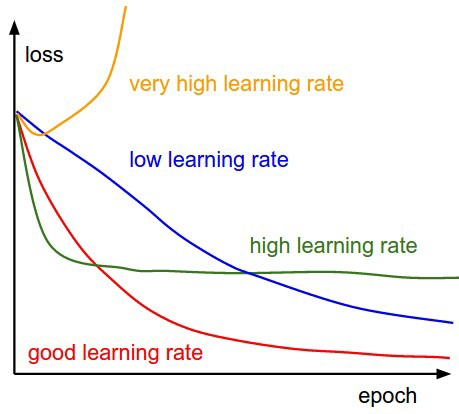
> Accuracy Plot (Source: [Useful Plots to Diagnose your Neural Network - Medium Towards](https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45))

As the plot shows, **val_loss** starts decreasing, **val_accuracy** starts increasing. It's lso fine as that means model built is learning and working fine.

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#### Confusion matrix

In [ ]:
# predict_ clases because is classification problem with the split test
predictions = model.predict_classes(testing_padded)   

In [ ]:
# Reference [2]
from sklearn.metrics import classification_report,confusion_matrix
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
# Showing Confusion Matrix
plot_cm(testing_labels,predictions, 'Confution matrix of Tweets', figsize=(7,7))

# Predicting

Now, it's time to classify the tweets from original test dataset, provided by Kaggle Competition. 

In [ ]:
# Sequencing
submission_sequences = tokenizer.texts_to_sequences(test_df.text)
# Padding
submission_padded = pad_sequences(submission_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [ ]:
# Apply model prediction on submission sequences
predictions = model.predict(submission_padded)

Below, we'll add the predicting outcomes to the submission file. 

In [ ]:
# sample of submission
submission.head()

In [ ]:
# Add target column to submission file
submission['target'] = (predictions > 0.5).astype(int)
submission.head(10)

In [ ]:
submission.to_csv("submission.csv", index=False, header=True)

### **If you like this notebook, please comment and upvote**

# References

1. [NLP Getting Started Tutorial - Phil Culliton](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial)
2. [Basic NLP with TensorFlow and WordCloud - Marco Vasquez E](https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#6.-Train-Test-Split)
3. [Basic EDA,Cleaning and GloVe -  Shahules](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#GloVe-for-Vectorization)
4. [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT - Vitalii Mokin](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert)
5. [NLP TensorFlow : Predicting sarcastic sentences - Wesley Galvão](https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences?scriptVersionId=40488767)
6. [Useful Plots to Diagnose your Neural Network - Medium Towards](https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45)